In [175]:
from pathlib import Path
import pandas as pd
import numpy as np

interim = Path('../data/interim')
processed = Path('../data/processed')
events = pd.read_pickle(Path(interim) / 'events.pkl')
game_logs = pd.read_pickle(Path(interim) / 'game_logs.pkl')

In [176]:
base = game_logs[['GAME_ID', 'HomeTeam', 'VisitingTeam', 'ParkID', 'HomeH', 'VisitorH']]
base['year'] = base['GAME_ID'].str.slice(3, 7)

<ipython-input-176-a2219e12dc9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['year'] = base['GAME_ID'].str.slice(3, 7)


In [177]:
Home = base.groupby(['HomeTeam', 'year', 'ParkID']).agg({'HomeH':'sum', 'VisitorH':'sum', 'GAME_ID':'nunique'})
Home.columns = ['home_hs', 'home_ha', 'home_g']
Home['home_factor'] = (Home['home_hs'] + Home['home_ha']) / Home['home_g']
Home = Home.rename_axis(['team', 'year', 'ParkID'])
Home

home_hs  home_ha  home_g  home_factor
team year ParkID                                       
ANA  2010 ANA01       662      692      81    16.716049
     2011 ANA01       664      685      81    16.654321
     2012 ANA01       720      638      81    16.765432
     2013 ANA01       741      745      81    18.345679
     2014 ANA01       701      672      81    16.950617
...                   ...      ...     ...          ...
WAS  2015 WAS11       681      678      81    16.777778
     2016 WAS11       674      646      81    16.296296
     2017 WAS11       791      670      81    18.037037
     2018 WAS11       725      691      81    17.481481
     2019 WAS11       743      722      81    18.086420

[321 rows x 4 columns]

In [178]:
Road = base.groupby(['VisitingTeam', 'year']).agg({'HomeH':'sum', 'VisitorH':'sum', 'GAME_ID':'nunique'})
Road.columns = ['road_ha', 'road_hs', 'road_g']
Road['road_factor'] = (Road['road_hs'] + Road['road_ha']) / Road['road_g']
Road = Road.rename_axis(['team', 'year'])
Road

road_ha  road_hs  road_g  road_factor
team year                                       
ANA  2010      730      701      81    17.666667
     2011      703      730      81    17.691358
     2012      701      798      81    18.506173
     2013      730      735      81    18.086420
     2014      635      763      81    17.259259
...            ...      ...     ...          ...
WAS  2015      688      682      81    16.913580
     2016      626      729      81    16.728395
     2017      630      686      81    16.246914
     2018      629      677      81    16.123457
     2019      618      717      81    16.481481

[300 rows x 4 columns]

In [195]:
park_factors = pd.merge(Home, Road, left_index=True, right_index=True)
park_factors['factor'] = park_factors['home_factor'] / park_factors['road_factor']
park_factors = park_factors.reset_index().set_index(['ParkID', 'year'])
park_factors = park_factors.sort_values(['team', 'year'])
# park_factors.loc[park_factors['factor'] > 1.3, 'factor'] = np.NaN
# park_factors.loc[park_factors['factor'] < .8, 'factor'] = np.NaN
park_factors['lag_factor'] = park_factors.groupby('ParkID')['factor'].shift(1)
park_factors

team  home_hs  home_ha  home_g  home_factor  road_ha  road_hs  \
ParkID year                                                                 
ANA01  2010  ANA      662      692      81    16.716049      730      701   
       2011  ANA      664      685      81    16.654321      703      730   
       2012  ANA      720      638      81    16.765432      701      798   
       2013  ANA      741      745      81    18.345679      730      735   
       2014  ANA      701      672      81    16.950617      635      763   
...          ...      ...      ...     ...          ...      ...      ...   
WAS11  2015  WAS      681      678      81    16.777778      688      682   
       2016  WAS      674      646      81    16.296296      626      729   
       2017  WAS      791      670      81    18.037037      630      686   
       2018  WAS      725      691      81    17.481481      629      677   
       2019  WAS      743      722      81    18.086420      618      717   

             road_g  road_factor    factor  lag_factor  
ParkID year                                             
ANA01  2010      81    17.666667  0.946191         NaN  
       2011      81    17.691358  0.941382    0.946191  
       2012      81    18.506173  0.905937    0.941382  
       2013      81    18.086420  1.014334    0.905937  
       2014      81    17.259259  0.982117    1.014334  
...             ...          ...       ...         ...  
WAS11  2015      81    16.913580  0.991971    1.075358  
       2016      81    16.728395  0.974170    0.991971  
       2017      81    16.246914  1.110182    0.974170  
       2018      81    16.123457  1.084227    1.110182  
       2019      81    16.481481  1.097378    1.084227  

[321 rows x 11 columns]

In [196]:
import statsmodels.formula.api as sm

In [197]:
result = sm.ols(formula="factor ~ lag_factor", data=park_factors).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 factor   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           1.08e-26
Time:                        22:51:32   Log-Likelihood:                 360.29
No. Observations:                 281   AIC:                            -716.6
Df Residuals:                     279   BIC:                            -709.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4521      0.046      9.765      0.0

<AxesSubplot:xlabel='lag_factor', ylabel='factor'>

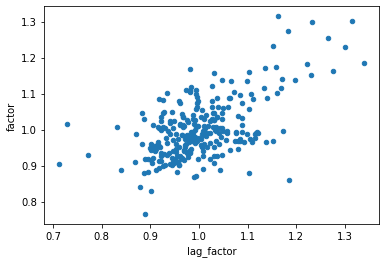

In [198]:
park_factors.plot.scatter(x='lag_factor', y='factor')

<AxesSubplot:>

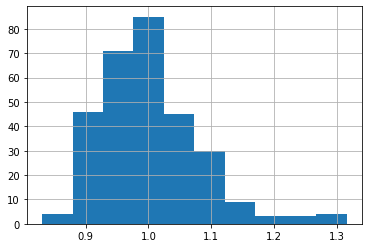

In [116]:
park_factors['factor'].hist()